## 1. Exploratoy Descriptive Analysis

In [2]:
import pandas as pd

C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
df1 = pd.read_csv(r'C:\Users\james\OneDrive\Desktop\DataSampleTest\combined_log_analysis.txt', sep='\t')

### Data Type

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 914060 entries, 0 to 914059
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Mac              914060 non-null  object 
 1   SessionMainMenu  914032 non-null  object 
 2   AppName          914060 non-null  object 
 3   LogID            914060 non-null  int64  
 4   Event            914060 non-null  object 
 5   ItemID           760938 non-null  object 
 6   RealTimePlaying  294031 non-null  float64
 7   # of days        0 non-null       float64
dtypes: float64(2), int64(1), object(5)
memory usage: 55.8+ MB


### Statistics

In [11]:
df1.describe()

,LogID,RealTimePlaying,# of days
count,914060.000000,2.940310e+05,0.0
mean,78.748688,1.237851e+03,NaN
std,122.856225,6.018782e+04,NaN
min,12.000000,1.500000e-01,NaN
25%,41.000000,5.713000e+00,NaN
50%,42.000000,1.628600e+01,NaN
75%,51.000000,2.557925e+02,NaN
max,512.000000,1.743658e+07,NaN


In [6]:
# Load the dataset
df = pd.read_csv(r'C:\Users\james\OneDrive\Desktop\DataSampleTest\user_retention.txt', sep='\t')

In [12]:
# Assume there's a column 'ServiceUsageCount' that holds the interaction count
average_interactions = df['InteractionCount'].mean()

# Define the churn threshold as one-third of the maximum interactions
churn_threshold = average_interactions 
print(f"Churn threshold: {churn_threshold}")



Churn threshold: 9.032829330961558


In [13]:
# Create a new column for churn labels
df['churn_label'] = df['InteractionCount'].apply(lambda x: 1 if x <= churn_threshold else 0)

# Check the distribution of churn labels
print(df['churn_label'].value_counts())

# Save the labeled data
df.to_csv(r'C:\Users\james\OneDrive\Desktop\DataSampleTest\churn_labeled_data.txt', sep='\t', index=False)


churn_label
1    77086
0    24104
Name: count, dtype: int64


### Data Visualization

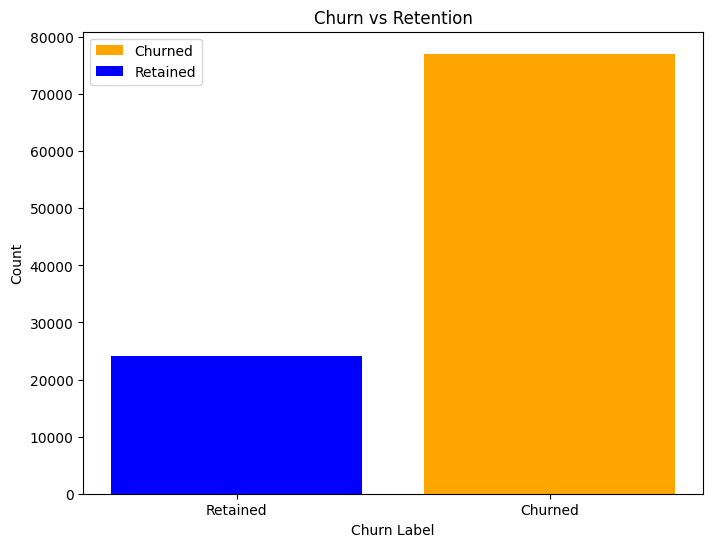

In [18]:
import matplotlib.pyplot as plt

# Assuming the data provided in the screenshot is stored in a dataframe
data = {'churn_label': [1, 0], 'count': [77086, 24104]}

# Create a DataFrame
df = pd.DataFrame(data)

# Create a stacked bar plot
plt.figure(figsize=(8, 6))
plt.bar(df['churn_label'], df['count'], color=['orange', 'blue'], label=['Churned', 'Retained'])

# Adding titles and labels
plt.title('Churn vs Retention')
plt.xlabel('Churn Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Retained', 'Churned'])
plt.legend()

# Show plot
plt.show()

## 2. Modeling

### Load data

In [5]:
combined_df = pd.read_csv(r'C:\Users\james\OneDrive\Desktop\DataSampleTest\combined_log_analysis.txt', sep='\t')

# Load the results from the analyses
service_usage_df = pd.read_csv(r'C:\Users\james\OneDrive\Desktop\DataSampleTest\service_usage_frequency.txt', sep='\t')
duration_analysis_df = pd.read_csv(r'C:\Users\james\OneDrive\Desktop\DataSampleTest\duration_analysis.txt', sep='\t')
top_content_df = pd.read_csv(r'C:\Users\james\OneDrive\Desktop\DataSampleTest\top_content_watched.txt', sep='\t')
app_engagement_df = pd.read_csv(r'C:\Users\james\OneDrive\Desktop\DataSampleTest\user_engagement_by_app.txt', sep='\t')
retention_df = pd.read_csv(r'C:\Users\james\OneDrive\Desktop\DataSampleTest\user_retention.txt', sep='\t')

# Assuming you also have a user churn label (1 = churn, 0 = not churn)
# This is usually historical data showing which users churned
labels_df = pd.read_csv(r'C:\Users\james\OneDrive\Desktop\DataSampleTest\churn_labeled_data.txt', sep='\t')


### Feature Engineering

In [6]:
# Feature 1: Service Usage Frequency
service_usage_df.rename(columns={'ServiceUsageCount': 'usage_freq'}, inplace=True)

# Feature 2: Total Time Spent
duration_analysis_df.rename(columns={'TotalTimeSpent': 'total_time_spent'}, inplace=True)

# Feature 3: Engagement with Top Content
top_content_threshold = top_content_df['WatchCount'].quantile(0.8)
top_content_df = top_content_df[top_content_df['WatchCount'] > top_content_threshold]  # Consider content with high engagement
combined_df['engagement_with_top_content'] = combined_df['ItemID'].apply(lambda x: 1 if x in top_content_df['ItemID'].values else 0)

# Feature 4: App Engagement Score (e.g., how many times a user used the most popular apps)
app_engagement_threshold = app_engagement_df['EngagementCount'].quantile(0.8)
app_engagement_df = app_engagement_df[app_engagement_df['EngagementCount'] > app_engagement_threshold]
combined_df['app_engagement_score'] = combined_df['AppName'].apply(lambda x: 1 if x in app_engagement_df['AppName'].values else 0)

# Feature 5: Retention Trend (simplified to count of interactions over time)
retention_trend = retention_df.groupby('Mac').size().reset_index(name='interaction_trend')

# Merge features into a single DataFrame
features_df = service_usage_df.merge(duration_analysis_df, on='Mac')
features_df = features_df.merge(combined_df[['Mac', 'engagement_with_top_content', 'app_engagement_score']], on='Mac')
features_df = features_df.merge(retention_trend, on='Mac')

### Prepare Labels

In [7]:
# Convert data types to reduce memory usage
features_df = features_df.astype({'usage_freq': 'int32', 'total_time_spent': 'float32', 'engagement_with_top_content': 'int8', 'app_engagement_score': 'int8', 'interaction_trend': 'int32'})
labels_df = labels_df.astype({'churn_label': 'int8'})

# Merge labels with features
final_df = features_df.merge(labels_df, on='Mac', how='inner')


In [8]:
# Randomly sample 10% of the data
sampled_df = final_df.sample(frac=0.1, random_state=42)

In [9]:
# Merge labels with features
sampled_df = features_df.merge(labels_df, on='Mac')

# Separate features and labels
X = sampled_df.drop(columns=['Mac', 'churn_label'])  # Features
y = sampled_df['churn_label']  # Labels

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Logistic Regression model
log_reg_model = LogisticRegression(random_state=42, max_iter=1000)
log_reg_model.fit(X_train, y_train)

# Predict on the test set
y_pred = log_reg_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

MemoryError: Unable to allocate 335. MiB for an array with shape (87861713,) and data type int32

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Train a RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

MemoryError: Unable to allocate 3.67 GiB for an array with shape (7, 70289370) and data type object

: 